In [2]:
# %pip install skforecast
# %pip install prophet
# %pip install statsmodels
# %pip install pmdarima

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.gofplots import qqplot
import itertools
import statsmodels.api as sm

In [5]:
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_absolute_percentage_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
from pmdarima import auto_arima


# Lectura de Datos



In [7]:
bikes = pd.read_csv('../files/SeoulBikeData.csv',encoding = 'unicode_escape')
bikes.head()

,Date,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes




> **Datos de un año completo**



In [8]:
bikes.shape

(8760, 14)

In [9]:
8760/24

365.0



> **Unimos la fecha y la hora para poder ordenar las observaciones a partir de una sola columna.**



In [10]:
def set_date_time(date, h):
  (d,m,y) = date.split('/')
  if h < 10:
    h0 = '0'+str(h)
  else:
    h0 = str(h)
  return y+'-'+m+'-'+d+' '+h0+':00:00'

In [11]:
dt = pd.to_datetime(bikes.apply(lambda r: set_date_time(r.Date, r.Hour), axis=1))
bikes['Date'] = dt
bikes

,Date,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day
0,2017-12-01 00:00:00,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01 01:00:00,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01 02:00:00,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01 03:00:00,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01 04:00:00,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30 19:00:00,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,2018-11-30 20:00:00,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,2018-11-30 21:00:00,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,2018-11-30 22:00:00,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes




> **Gráfica de la serie de tiempo.**



In [12]:
# Check the column names of the dataframe
print(bikes.columns)

Index(['Date', 'Rented_Bike_Count', 'Hour', 'Temperature', 'Humidity',
       'Wind_speed', 'Visibility', 'Dew_point_temperature', 'Solar_Radiation',
       'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Functioning_Day'],
      dtype='object')


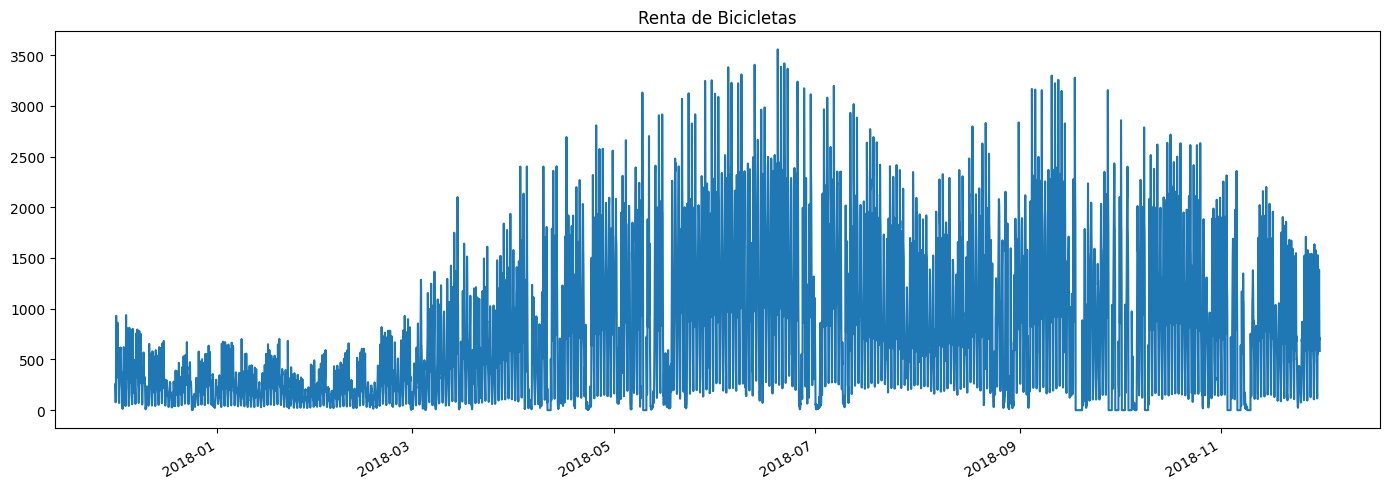

In [14]:
x = bikes['Date']
y = bikes['Rented_Bike_Count']
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(x, y)
ax.set_title('Renta de Bicicletas')
fig.autofmt_xdate()
plt.tight_layout()

# Exploración de Datos

Revisemos las últimas semanas.

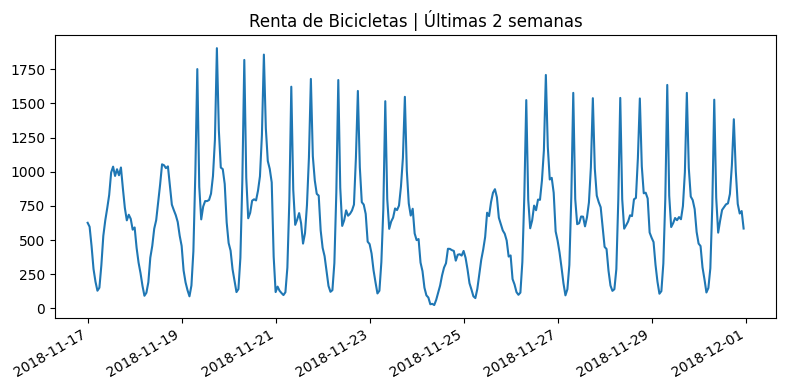

In [16]:
x = bikes['Date'].iloc[(-24*14):]
y = bikes['Rented_Bike_Count'].iloc[(-24*14):]
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.set_title('Renta de Bicicletas | Últimas 2 semanas')
fig.autofmt_xdate()
plt.tight_layout()

<font color="red">Actividad</font>

* Accede al tablero del CONACyT sobre los contagios por COVID en México: https://datos.covid-19.conacyt.mx/
* Descarga los datos de contagios diarios (panel de la izquierda)
* Construye la serie de tiempo de los casos a nivel nacional.
* Construye la serie de tiempo de los casos en Quintana Roo.

*   Describe las características de las series de tiempo obtenidas.
*   Entregable: Libreta de Colab